# ODE SOLVER USING NEURAL NETWORK

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib_inline.backend_inline import set_matplotlib_formats

set_matplotlib_formats("svg")

In [2]:
# x = torch.cuda.current_device()
# x

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
x = torch.linspace(0, 1, 10).unsqueeze(1).to(device=device)
print(x.shape)
print(x.unsqueeze(1).shape)
x

torch.Size([10, 1])
torch.Size([10, 1, 1])


tensor([[0.0000],
        [0.1111],
        [0.2222],
        [0.3333],
        [0.4444],
        [0.5556],
        [0.6667],
        [0.7778],
        [0.8889],
        [1.0000]], device='cuda:0')

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.Hidden_layer = nn.Linear(in_features=1, out_features=10)
        self.Output_layer = nn.Linear(in_features=10, out_features=1, bias=False)
        self.Sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.Hidden_layer(x)
        x = self.Sigmoid(x)
        output = self.Output_layer(x)
        return output

In [6]:
NeuralNetwork()

NeuralNetwork(
  (Hidden_layer): Linear(in_features=1, out_features=10, bias=True)
  (Output_layer): Linear(in_features=10, out_features=1, bias=False)
  (Sigmoid): Sigmoid()
)

In [7]:
class LSTM_Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=1, num_layers=1, batch_first=True)
        # self.output_layer = nn.Linear(10, 1, bias=False) # if hidden_size=10

    def forward(self, x):
        x = x.unsqueeze(-1)  # Ensure input shape is (batch, seq_len, input_size)
        lstm_out, _ = self.lstm(x)
        # output = self.output_layer(lstm_out) # if hidden_size=10
        output = lstm_out
        return output.squeeze(-1)  # Remove last dimension for consistency

In [8]:
LSTM_Network()

LSTM_Network(
  (lstm): LSTM(1, 1, batch_first=True)
)

## Example Problem 1

ODE: 

\begin{equation}
    \frac{dy}{dx} + (x + \frac{1+3x^2}{1+x+x^3})y = x^3+2x+x^2\frac{1+3x^2}{1+x+x^3}
\end{equation}

Let

\begin{equation}
    f(x):= x^3+2x+x^2\frac{1+3x^2}{1+x+x^3}
\end{equation}

\begin{equation}
    p(x):= (x + \frac{1+3x^2}{1+x+x^3})
\end{equation}

\begin{equation}
    y(0) = 1
\end{equation}

\begin{equation}
    x \in [0,1]
\end{equation}

Exact (actual) solution of above ODE is:

\begin{equation}
    y_a(x):= \frac{e^{-x^2/2}}{1+x+x^3} + x^2
\end{equation}

Trail solution is of the form:

\begin{equation}
    y(x)_t = 1 + xN(x)
\end{equation}


In [9]:
# For Example Problem 1 Only


def f(x):
    return x**3 + 2 * x + x**2 * ((1 + 3 * x**2) / (1 + x + x**3))


def p(x):
    return x + ((1 + 3 * x**2) / (1 + x + x**3))


def y_exact(x):
    return torch.exp(-(x**2) / 2) / (1 + x + x**3) + x**2


def y_trail(x, N):
    return 1 + x * N(x)


def loss_1(x, N):
    x.requires_grad = True
    y = y_trail(x, N)
    dy_dx = torch.autograd.grad(y.sum(), x, create_graph=True)[0]
    G = (dy_dx + p(x) * y - f(x)) ** 2

    return torch.sum(G)

In [10]:
# def Optimize(x, epochs, N):
#     optimizer = torch.optim.LBFGS(N.parameters())

#     def train():
#         optimizer.zero_grad()
#         l = loss_1(x, N)
#         l.backward()

#         return l

#     for i in tqdm(range(epochs)):
#         optimizer.step(train)
def Optimize(x, epochs, N):
    optimizer = torch.optim.LBFGS(N.parameters())

    def train():
        with torch.backends.cudnn.flags(enabled=False):
            optimizer.zero_grad()
            l = loss_1(x, N)
            l.backward()
        return l

    for _ in tqdm(range(epochs)):
        optimizer.step(train)

In [11]:
def Plot_solutions(xx, N):
    with torch.no_grad():
        yy = y_trail(xx, N).detach().cpu()
        xx = xx.detach().cpu()

    plt.figure(figsize=(6, 5))
    plt.plot(
        xx,
        y_exact(xx),
        "--",
        label="Exact",
        color="darkorange",
        linewidth=1.5,
        antialiased=True,
    )
    plt.plot(
        xx,
        yy,
        "*",
        label="Predicted",
        color="royalblue",
        linewidth=2.5,
        antialiased=True,
    )

    # Making plot visually good
    plt.xlabel(
        "x", fontsize=10, fontweight="bold", labelpad=10
    )  # Increase font size for labels
    plt.ylabel("y", fontsize=10, fontweight="bold", labelpad=10)
    plt.legend(fontsize=10, loc="best", frameon=True)  # Adjust legend font size
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)  # Dashed grid lines
    plt.title(
        "Predicted vs Exact Solution", fontsize=12, fontweight="bold", pad=20
    )  # Add a title
    plt.xticks(fontsize=10)  # Customize x-axis tick size
    plt.yticks(fontsize=10)  # Customize y-axis tick size
    plt.tight_layout()  # Ensure labels and titles fit within the plot
    plt.show()

In [12]:
def MSE_Calculate(xx, N):
    with torch.no_grad():
        yy = y_trail(xx, N).detach().cpu()
        xx = xx.detach().cpu()

    mse = torch.mean((yy - y_exact(xx)) ** 2)
    print(f"MSE: {mse}")

In [13]:
EPOCHS = 10

100%|██████████| 10/10 [00:01<00:00,  5.08it/s]

MSE: 1.9143287649514562e-11


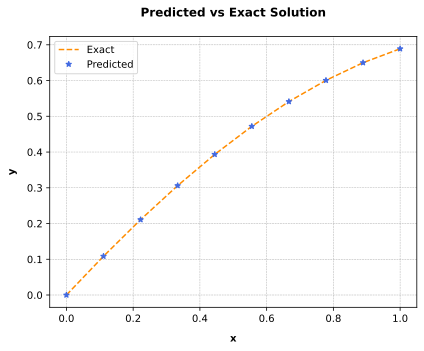

In [23]:
# Example Problem 1 Solution

X = torch.linspace(start=0, end=1, steps=10).unsqueeze(1).to(device=device)
# N = NeuralNetwork().to(device=device)
N = LSTM_Network().to(device=device)

Optimize(X, EPOCHS, N)
MSE_Calculate(X, N)
Plot_solutions(X, N)

## Example Problem 2

ODE: 

\begin{equation}
    \frac{dy}{dx} + \frac{1}{5}y = e^{-x/5}cos(x)
\end{equation}

Let

\begin{equation}
    f(x):= e^{-x/5}cos(x)
\end{equation}

\begin{equation}
    p(x):= \frac{1}{5}
\end{equation}

\begin{equation}
    y(0) = 0
\end{equation}

\begin{equation}
    x \in [0,2]
\end{equation}

Exact (actual) solution of above ODE is:

\begin{equation}
    y_a(x):= e^{-x/5}sin(x)
\end{equation}

Train solution is of the form:

\begin{equation}
    y(x)_t = xN(x)
\end{equation}

In [15]:
# For Example 2 Only


def f(x):
    return torch.exp(-x / 5) * torch.cos(x)


def p(x):
    return 1 / 5


def y_exact(x):
    return torch.exp(-x / 5) * torch.sin(x)


def y_trail(x, N):
    return x * N(x)


def loss_1(x, N):
    x.requires_grad = True
    y = y_trail(x, N)
    dy_dx = torch.autograd.grad(y.sum(), x, create_graph=True)[0]
    G = (dy_dx + p(x) * y - f(x)) ** 2
    return torch.sum(G)

100%|██████████| 10/10 [00:00<00:00, 12.52it/s]

MSE: 6.996181520398104e-13


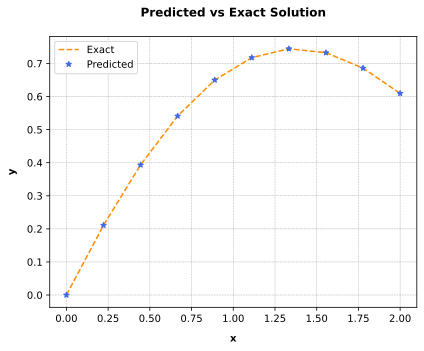

In [24]:
# Example Problem 2 Solution

X = torch.linspace(start=0, end=2, steps=10).unsqueeze(1).to(device=device)
# N = NeuralNetwork().to(device=device)
N = LSTM_Network().to(device=device)

Optimize(X, EPOCHS, N)
MSE_Calculate(X, N)
Plot_solutions(X, N)

## Example Problem 3

ODE: 

\begin{equation}
    \frac{d^2y}{dx^2} + \frac{1}{5}\frac{dy}{dx} + y = -\frac{1}{5}e^{-x/5}cos(x)
\end{equation}

Let

\begin{equation}
    f(x):= e^{-x/5}cos(x)
\end{equation}

\begin{equation}
    p(x):= \frac{1}{5}
\end{equation}

\begin{equation}
    \begin{cases}
        y(0) = 0 \\
        \frac{d}{dx}y(0) = 1 \\
        y(1) = sin(1)e^{-1/5}
    \end{cases}
    
\end{equation}

\begin{equation}
    x \in [0,2]
\end{equation}

Exact (actual) solution of above ODE is:

\begin{equation}
    y_a(x):= e^{-x/5}sin(x)
\end{equation}

Train solution is of the form:

\begin{equation}
    y(x)_t = xsin(1)e^{-1/5} + x(1-x)N(x)
\end{equation}



In [17]:
# For Example 3 Only


def f(x):
    return -(1 / 5) * torch.exp(-x / 5) * torch.cos(x)


def p(x):
    return 1


def q(x):
    return 1 / 5


def y_exact(x):
    return torch.exp(-x / 5) * torch.sin(x)


def y_trail(x, N):
    return x * torch.sin(torch.tensor(1)) * torch.exp(torch.tensor(-1 / 5)) + x * (
        1 - x
    ) * N(x)


def loss_1(x, N):
    x.requires_grad = True
    y = y_trail(x, N)
    dy_dx = torch.autograd.grad(y.sum(), x, create_graph=True)[0]
    d2y_dx2 = torch.autograd.grad(dy_dx.sum(), x, create_graph=True)[0]
    G = (d2y_dx2 + q(x) * dy_dx + p(x) * y - f(x)) ** 2
    return torch.sum(G)

100%|██████████| 10/10 [00:00<00:00, 25.70it/s]

MSE: 3.148941177255615e-11



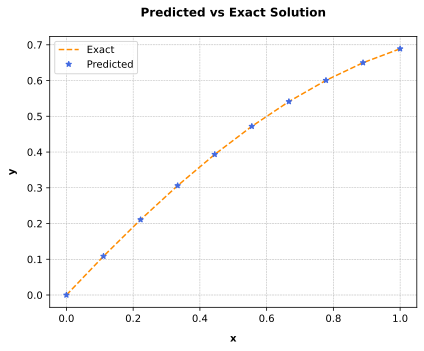

In [18]:
# Example Problem 3 Solution

X3 = torch.linspace(start=0, end=1, steps=10).unsqueeze(1).to(device=device)
# N3 = NeuralNetwork().to(device=device)
N3 = LSTM_Network().to(device=device)

Optimize(X3, EPOCHS, N3)
MSE_Calculate(X3, N3)
print("")
Plot_solutions(X3, N3)

In [19]:
print("All Done!")

All Done!
